In [1]:
from pathlib import Path
import numpy as np
from flygym.arena import FlatTerrain
from dm_control.mujoco import Camera as DMCamera
import matplotlib.pyplot as plt
from tqdm import trange

plt.rcParams["font.family"] = "Arial"
plt.rcParams["pdf.fonttype"] = 42

In [2]:
from generate_slope_datapts import *

fly = Fly("0", enable_adhesion=True, draw_adhesion=True, actuator_gain=45)
fly.model.visual.map.zfar = 100
getattr(fly.model.visual, "global").offheight = 800
cam_elem = fly.model.find("camera", "camera_right")
cam_elem.focal = [80, 80]
cam_elem.sensorsize = [1, 1]
cam_elem.resolution = [400, 400]
cam_elem.pos[1] = -400
cam_elem.euler[:] = (np.pi / 2, np.pi / 2, 0)

cam = Camera(
    fly=fly,
    camera_id="Animat/camera_right",
    play_speed_text=False,
    window_size=(400, 400),
)
sim = SingleFlySimulation(
    fly=fly,
    cameras=[cam],
    arena=FlatTerrain(ground_alpha=0),
)
sim.reset()

dm_camera = DMCamera(
    sim.physics,
    camera_id="0/camera_right",
    width=400,
    height=400,
)

n_stabilization_steps = int(STABILIZATION_DUR / sim.timestep)
gravity_switching_step = int(GRAVITY_SWITCHING_T / sim.timestep)

num_steps = int(RUN_TIME / sim.timestep) + n_stabilization_steps

(
    frequencies,
    target_amplitudes,
    rates,
    phase_biases,
    coupling_weights,
) = get_CPG_parameters()

# Initilize the simulation
np.random.seed(CONTROLLER_SEED)
start_ampl = np.ones(6) * 0.2

cpg_network = CPGNetwork(
    timestep=sim.timestep,
    intrinsic_freqs=frequencies,
    intrinsic_amps=start_ampl,
    coupling_weights=coupling_weights,
    phase_biases=phase_biases,
    convergence_coefs=rates,
    init_magnitudes=start_ampl,
    seed=CONTROLLER_SEED,
)

# Initalize storage
traj = []
M_list = []
slope = 90

for i in trange(num_steps):
    cpg_network.step()
    phase = cpg_network.curr_phases
    amp = cpg_network.curr_magnitudes

    if i == n_stabilization_steps:
        # Now set the amplitude to their real values
        cpg_network.intrinsic_amps[:] = target_amplitudes
    if i == gravity_switching_step:
        sim.set_slope(slope, "y")
    if i <= n_stabilization_steps:
        phase = phase * 0

    joints_angles = []
    adhesion_onoff = []

    for j, leg in enumerate(preprogrammed_steps.legs):
        my_joints_angles = preprogrammed_steps.get_joint_angles(leg, phase[j], amp[j])
        joints_angles.append(my_joints_angles)
        my_adhesion_onoff = preprogrammed_steps.get_adhesion_onoff(leg, phase[j])
        adhesion_onoff.append(my_adhesion_onoff)

    action = {
        "joints": np.concatenate(joints_angles),
        "adhesion": np.array(adhesion_onoff).astype(int),
    }

    try:
        obs = sim.step(action)[0]
        if i >= gravity_switching_step:
            traj.append(obs["fly"][0])
            if sim.render()[0] is not None:
                M_list.append(dm_camera.matrix.copy())
    except Exception as e:
        print(e)
        break

100%|██████████| 8999/8999 [00:11<00:00, 758.58it/s]


In [3]:
traj = np.array(traj)
M_list = np.array(M_list)

In [4]:
i = 100
M = M_list[i]
img = cam._frames[i]

In [5]:
traj_ = np.column_stack((traj, np.ones(len(traj)))) @ M.T
traj_ = traj_[:, :2] / traj_[:, 2, None]

In [15]:
o = M @ (0, 0, 0, 1)
x = M @ (1, 0, 0, 1)
z = M @ (0, 0, 1, 1)
o = o[:2] / o[2]
dx = x[:2] / x[2] - o
dz = z[:2] / z[2] - o

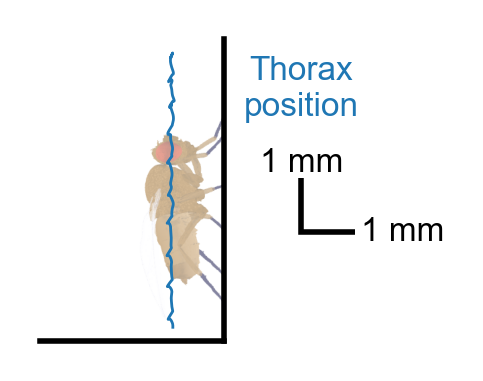

In [16]:
h = 19.162 / 25.4
w = 12.171 / 25.4
fig, ax = plt.subplots(1, 1, figsize=(w, h), dpi=400)
fig.subplots_adjust(0, 0, 1, 1, 0, 0)
ax.imshow(img, alpha=0.5)
ax.plot(*traj_[800:-300].T, linewidth=0.5)
ax.set_xticks([])
ax.set_yticks([])
for spine in ["left", "top"]:
    ax.spines[spine].set_visible(False)
ax.set_xlim(None, 274)
for sp in ax.spines.values():
    sp.set_linewidth(1)

p0 = (390, 260)
p1 = p0 - dz
p2 = p0 + dx
ax.plot(
    *zip(p1, p0, p2),
    clip_on=False,
    color="k",
    lw=1,
    solid_capstyle="butt",
    solid_joinstyle="miter"
)
ax.annotate(
    "1 mm",
    p2,
    (0, 0),
    annotation_clip=False,
    clip_on=False,
    size=6,
    textcoords="offset points",
    ha="center",
    va="bottom",
)
ax.annotate(
    "1 mm",
    p1,
    (1, 0),
    annotation_clip=False,
    clip_on=False,
    size=6,
    textcoords="offset points",
    ha="left",
    va="center",
)
ax.annotate(
    "Thorax\nposition",
    p2,
    (0, 10),
    annotation_clip=False,
    clip_on=False,
    size=6,
    textcoords="offset points",
    ha="center",
    va="bottom",
    color="C0",
)
Path("outputs").mkdir(exist_ok=True)
plt.savefig(
    "outputs/climbing.pdf", bbox_inches="tight", pad_inches=0, transparent=True, dpi=600
)